In [253]:
import pandas as pd
import json

import numpy as np
import matplotlib.pyplot as plt

import pickle 
import re

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
sns.set_style("darkgrid")
from copy import deepcopy
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%pylab inline

%matplotlib inline

%time

Populating the interactive namespace from numpy and matplotlib
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


## Small Feature Set --- balanced

In [2]:
with open("../Data/TripDf.pkl", 'rb') as picklefile: 
    TripAnalysis = pickle.load(picklefile)

In [3]:
TripAnalysis.head()

,TripType,VisitNumber,Weekday,Sunday,Saturday,Friday,Thursday,Wednesday,Tuesday,Monday,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotProdts,CatBought
0,999,5,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,30,7,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2
2,26,8,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,6
3,8,9,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2
4,8,10,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2


In [4]:
TripAnalysis['TripType'].unique()

array([999,  30,  26,   8,  35,  41,  21,   6,  42,   7,   9,  39,  25,
        38,  15,  36,  20,  37,  32,  40,   5,   3,   4,  24,  33,  43,
        31,  27,  34,  18,  29,  44,  19,  23,  22,  28,  14,  12])

In [5]:
TripAnalysis['TripType'].nunique()

38

In [6]:
TripAnalysis['TripType'].value_counts()

8      12161
39      9896
9       9464
999     8286
40      6130
7       5752
5       4593
25      3698
3       3643
36      3005
38      2912
37      2788
24      2609
35      2030
32      1984
42      1858
33      1315
6       1277
44      1187
30      1081
15       978
22       928
43       872
27       785
34       719
21       641
20       637
31       594
41       583
18       549
26       503
28       492
29       433
19       375
4        346
12       269
23       139
14         4
Name: TripType, dtype: int64

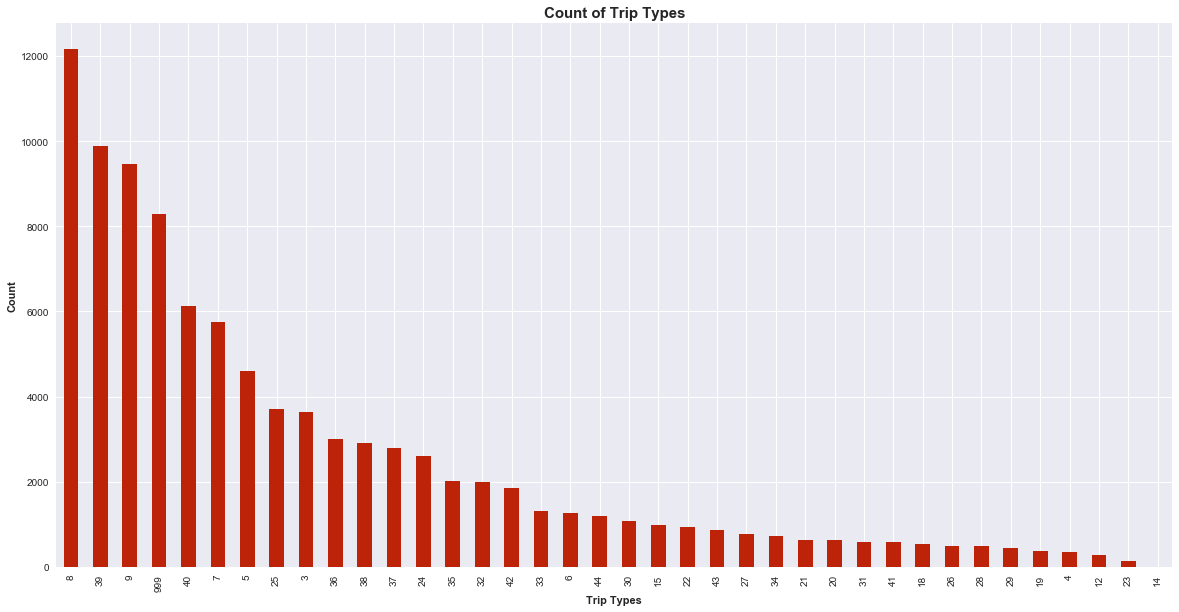

In [262]:
TripAnalysis['TripType'].value_counts().plot(kind='bar',figsize=(20,10), color = '#bd2309' )
plt.title('Count of Trip Types',fontweight='bold',fontsize=15)
plt.ylabel('Count',fontweight='bold')
plt.xlabel("Trip Types", fontweight='bold')
plt.show()

In [8]:
TripAnalysis.head()

,TripType,VisitNumber,Weekday,Sunday,Saturday,Friday,Thursday,Wednesday,Tuesday,Monday,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotProdts,CatBought
0,999,5,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,30,7,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2
2,26,8,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,6
3,8,9,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2
4,8,10,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2


### Balance the classes

#### Drop classes with sample smaller than 500

In [10]:
TripAnalysis.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Sunday', 'Saturday', 'Friday',
       'Thursday', 'Wednesday', 'Tuesday', 'Monday', '1-HR PHOTO',
       'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY',
       'BEDDING', 'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
       'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
       'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
       'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
       'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
       'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS', 'HOME DECOR',
       'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
       'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
       'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
       'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
       'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
       'MEAT - F

In [14]:
TripBal= TripAnalysis.filter(['TripType', 'VisitNumber', 'Weekday', 'Sunday', 'Saturday', 'Friday',
       'Thursday', 'Wednesday', 'Tuesday', 'Monday', '1-HR PHOTO',
       'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY',
       'BEDDING', 'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
       'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
       'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
       'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
       'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
       'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS', 'HOME DECOR',
       'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
       'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
       'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
       'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
       'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
       'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENS WEAR', 'MENSWEAR',
       'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
       'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
       'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
       'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
       'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
       'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
       'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS', 'TotProdts', 'CatBought'])

In [15]:
TripBal = TripBal[TripBal.TripType != 28]
TripBal = TripBal[TripBal.TripType != 29]
TripBal = TripBal[TripBal.TripType != 19]
TripBal = TripBal[TripBal.TripType != 4]
TripBal = TripBal[TripBal.TripType != 12]
TripBal = TripBal[TripBal.TripType != 23]
TripBal = TripBal[TripBal.TripType != 14] 

In [16]:
from sklearn.utils import resample

In [78]:
TripBal.dtypes

TripType                     int64
VisitNumber                  int64
Weekday                     object
Sunday                     float64
Saturday                   float64
Friday                     float64
Thursday                   float64
Wednesday                  float64
Tuesday                    float64
Monday                     float64
1-HR PHOTO                 float64
ACCESSORIES                float64
AUTOMOTIVE                 float64
BAKERY                     float64
BATH AND SHOWER            float64
BEAUTY                     float64
BEDDING                    float64
BOOKS AND MAGAZINES        float64
BOYS WEAR                  float64
BRAS & SHAPEWEAR           float64
CAMERAS AND SUPPLIES       float64
CANDY, TOBACCO, COOKIES    float64
CELEBRATION                float64
COMM BREAD                 float64
CONCEPT STORES             float64
COOK AND DINE              float64
DAIRY                      float64
DSD GROCERY                float64
ELECTRONICS         

In [17]:
TripBal.TripType.value_counts()

8      12161
39      9896
9       9464
999     8286
40      6130
7       5752
5       4593
25      3698
3       3643
36      3005
38      2912
37      2788
24      2609
35      2030
32      1984
42      1858
33      1315
6       1277
44      1187
30      1081
15       978
22       928
43       872
27       785
34       719
21       641
20       637
31       594
41       583
18       549
26       503
Name: TripType, dtype: int64

### Lets take median sample size of the classes/labels --- Use this value to upsample/downsample ~ 1800



#### Creating an empty DF with only 2rows of data....this DF will be concatenated with balanced classes from each class

In [87]:
Df_Bal = TripBal.iloc[:2,:]

In [88]:
Df_Bal.head()

,TripType,VisitNumber,Weekday,Sunday,Saturday,Friday,Thursday,Wednesday,Tuesday,Monday,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotProdts,CatBought
0,999,5,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,30,7,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2


In [91]:
# if sample less than 1800  then upsample with replacement else downnsample without replacement

for i in listTripType:
    if (TripBal.loc[(TripBal['TripType']== i)].TripType.count()) > 1800:
        DF_i = resample(TripBal.loc[(TripBal['TripType']== i)],replace=False, n_samples=1800, random_state=42)
    else:
        DF_i = resample(TripBal.loc[(TripBal['TripType']== i)],replace=True, n_samples=1800, random_state=42)
    Df_Bal = pd.concat([Df_Bal, DF_i])


In [92]:
Df_Bal.reset_index(drop=True, inplace=True)

In [93]:
Df_Bal.head()

,TripType,VisitNumber,Weekday,Sunday,Saturday,Friday,Thursday,Wednesday,Tuesday,Monday,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotProdts,CatBought
0,999,5,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,30,7,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2
2,999,140278,Saturday,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,999,19528,Sunday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3
4,999,102008,Sunday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [100]:
Df_Bal.dtypes

TripType                     int64
VisitNumber                  int64
Weekday                     object
Sunday                     float64
Saturday                   float64
Friday                     float64
Thursday                   float64
Wednesday                  float64
Tuesday                    float64
Monday                     float64
1-HR PHOTO                 float64
ACCESSORIES                float64
AUTOMOTIVE                 float64
BAKERY                     float64
BATH AND SHOWER            float64
BEAUTY                     float64
BEDDING                    float64
BOOKS AND MAGAZINES        float64
BOYS WEAR                  float64
BRAS & SHAPEWEAR           float64
CAMERAS AND SUPPLIES       float64
CANDY, TOBACCO, COOKIES    float64
CELEBRATION                float64
COMM BREAD                 float64
CONCEPT STORES             float64
COOK AND DINE              float64
DAIRY                      float64
DSD GROCERY                float64
ELECTRONICS         

In [101]:
Df_Bal.TripType.value_counts()

999    1801
30     1801
31     1800
40     1800
33     1800
34     1800
3      1800
35     1800
36     1800
5      1800
37     1800
6      1800
38     1800
7      1800
39     1800
8      1800
9      1800
41     1800
42     1800
43     1800
44     1800
15     1800
18     1800
20     1800
21     1800
22     1800
24     1800
25     1800
26     1800
27     1800
32     1800
Name: TripType, dtype: int64

In [116]:
# Deleting the 1st 2 extra rows that were used to create the DF initially
Df_Bal =Df_Bal.iloc[2:,]

In [117]:
Df_Bal.TripType.value_counts()

31     1800
40     1800
33     1800
34     1800
3      1800
35     1800
36     1800
5      1800
37     1800
6      1800
38     1800
7      1800
39     1800
999    1800
8      1800
9      1800
30     1800
41     1800
42     1800
43     1800
44     1800
15     1800
18     1800
20     1800
21     1800
22     1800
24     1800
25     1800
26     1800
27     1800
32     1800
Name: TripType, dtype: int64

In [102]:
with open('../Data/SmallBalDf.pkl', 'wb') as picklefile2:
    pickle.dump(Df_Bal, picklefile2)

In [103]:
!ls ../Data

BalncedDf.pkl         TripDf.pkl            test.csv
Cat Analysis.xlsx     TripFeatureDf.pkl     train.csv
FullTripDf.pkl        TripFullDf.pkl        ~$Cat Analysis.xlsx
SmallBalDf.pkl        sample_submission.csv


In [104]:
with open("../Data/SmallBalDf.pkl", 'rb') as picklefile3: 
    TripSmallBal= pickle.load(picklefile3)

In [105]:
TripSmallBal.head()

,TripType,VisitNumber,Weekday,Sunday,Saturday,Friday,Thursday,Wednesday,Tuesday,Monday,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotProdts,CatBought
0,999,5,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,30,7,Friday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2
2,999,140278,Saturday,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,999,19528,Sunday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3
4,999,102008,Sunday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [245]:
TripSmallBal.TripType.nunique()

31

## Data Split , Test:Train = 70:30

In [106]:
from sklearn.cross_validation import train_test_split

In [107]:
TripSmallBal.dtypes

TripType                     int64
VisitNumber                  int64
Weekday                     object
Sunday                     float64
Saturday                   float64
Friday                     float64
Thursday                   float64
Wednesday                  float64
Tuesday                    float64
Monday                     float64
1-HR PHOTO                 float64
ACCESSORIES                float64
AUTOMOTIVE                 float64
BAKERY                     float64
BATH AND SHOWER            float64
BEAUTY                     float64
BEDDING                    float64
BOOKS AND MAGAZINES        float64
BOYS WEAR                  float64
BRAS & SHAPEWEAR           float64
CAMERAS AND SUPPLIES       float64
CANDY, TOBACCO, COOKIES    float64
CELEBRATION                float64
COMM BREAD                 float64
CONCEPT STORES             float64
COOK AND DINE              float64
DAIRY                      float64
DSD GROCERY                float64
ELECTRONICS         

In [108]:
X = TripSmallBal.loc[:,'Saturday':]
y = TripSmallBal.loc[:,'TripType']

In [110]:
X.head()

,Saturday,Friday,Thursday,Wednesday,Tuesday,Monday,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotProdts,CatBought
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [111]:
y.head()

0    999
1     30
2    999
3    999
4    999
Name: TripType, dtype: int64

In [231]:
print(X.shape,y.shape)

(55802, 76) (55802,)


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify =y)

In [113]:
len(y_train)/len(y_test)

2.333253688549071

In [233]:
print(X_test.shape,y_test.shape,X_train.shape,y_train.shape)

(16741, 76) (16741,) (39061, 76) (39061,)


In [118]:
1260/540   #Check ratio for class 8

2.3333333333333335

In [119]:
y_train.unique()

array([ 43,  24,  22,  15,   8,   7,  35,  40,  42,  26,  44,  41,  39,
        21,  37,  33,   6, 999,  27,  34,  30,  36,  32,   9,  31,  20,
        25,   3,  18,  38,   5])

In [234]:
print(y_train.nunique(),y_test.nunique())

31 31


### Logistic Regression

In [120]:
from sklearn.linear_model import LogisticRegression

#### multi_class :  default: ‘ovr’

In [122]:
%%time
logreg = LogisticRegression()           #class_weight='balanced' already
logreg.fit(X_train, y_train)

y_log_pred_train = logreg.predict(X_train)
print('Logistic Regression Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_log_pred_train))

Logistic Regression Accuracy Score (Train)= 0.674125086403
CPU times: user 21 s, sys: 131 ms, total: 21.1 s
Wall time: 21.2 s


In [123]:
%%time
y_Log_pred = logreg.predict(X_test)
print('Logistic Regression Accuracy Score(Test)=',metrics.accuracy_score(y_test, y_Log_pred))

Logistic Regression Accuracy Score(Test)= 0.667403380921
CPU times: user 36.1 ms, sys: 20.6 ms, total: 56.7 ms
Wall time: 43 ms


#### For multi_class its better to use ‘multinomial’  ---->  solver = 'newton-cg'

Note: Need to add solver =  ‘newton-cg’, ‘sag’ or ‘lbfgs’  
As the default solver ‘liblinear’ doesn't support multinomial

In [125]:
%time
logreg = LogisticRegression(multi_class= 'multinomial', solver = 'newton-cg')   # class_weight='balanced' already
logreg.fit(X_train, y_train)
y_log_pred_train = logreg.predict(X_train)
print('Logistic Regression Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_log_pred_train))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Logistic Regression Accuracy Score (Train)= 0.677939632882


In [127]:
%%time
y_Log_pred_test = logreg.predict(X_test)
print('Logistic Regression Accuracy Score(Test)=',metrics.accuracy_score(y_test, y_Log_pred_test))

Logistic Regression Accuracy Score(Test)= 0.669732990861
CPU times: user 27.8 ms, sys: 8.7 ms, total: 36.5 ms
Wall time: 24.5 ms


In [135]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTrain = metrics.recall_score(y_train, y_log_pred_train, average='micro')
print('Recall micro-average for Logistic Regression (Train) =', RecallTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTest = metrics.recall_score(y_test, y_Log_pred, average='micro')
print('Recall micro-average for Logistic Regression (Test) =', RecallTest)

Recall micro-average for Logistic Regression (Train) = 0.677939632882
Recall micro-average for Logistic Regression (Test) = 0.669732990861


In [129]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTrain = metrics.precision_score(y_train, y_log_pred_train, average='micro')
print('Precision micro-average for Logistic Regression (Train) =', PrecisionTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTest = metrics.precision_score(y_test, y_Log_pred_test, average='micro')
print('Precision micro-average for Logistic Regression (Test) =', PrecisionTest)

Precision micro-average for Logistic Regression (Train) = 0.677939632882
Precision micro-average for Logistic Regression (Test) = 0.669732990861


In [130]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Train = metrics.f1_score(y_train, y_log_pred_train, average='micro')
print('F1_score micro-average for Logistic Regression (Train) =', F1Train)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Test = metrics.f1_score(y_test, y_Log_pred_test, average='micro')
print('F1_score micro-average for Logistic Regression (Test) =', F1Test)

F1_score micro-average for Logistic Regression (Train) = 0.677939632882
F1_score micro-average for Logistic Regression (Test) = 0.669732990861


In [131]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy: %.3f"% accuracy_score(y_test, y_Log_pred_test))
print(classification_report(y_test, logreg.predict(X_test)))

Accuracy: 0.670
             precision    recall  f1-score   support

          3       0.86      0.94      0.90       540
          5       0.78      0.88      0.83       540
          6       0.81      0.86      0.84       540
          7       0.62      0.69      0.65       540
          8       0.54      0.77      0.63       540
          9       0.47      0.53      0.50       540
         15       0.60      0.49      0.54       540
         18       0.72      0.69      0.71       540
         20       0.81      0.83      0.82       540
         21       0.73      0.79      0.76       540
         22       0.74      0.84      0.79       540
         24       0.61      0.59      0.60       540
         25       0.63      0.73      0.68       540
         26       0.71      0.74      0.72       540
         27       0.80      0.77      0.78       540
         30       0.61      0.74      0.67       541
         31       0.92      0.93      0.92       540
         32       0.76      0

#### Confusion Matrix - Logistic Regression - Multinomial

In [136]:
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
import seaborn
seaborn.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [137]:
def plot_confusion(title_plot,y_test, y_pred):
    
    #y_pred = clf.predict(x)
    c_mat = confusion_matrix(y_test,y_pred)
    labels = unique(y_test)
    seaborn.heatmap(
        sqrt(c_mat),
        annot=c_mat,
        xticklabels=labels,
        yticklabels=labels,
        cbar=False);
    ylabel("True Label", fontsize = 'large',fontweight ='bold' )
    xlabel("Predicted Label", fontsize = 'large',fontweight ='bold' )
    title(title_plot, fontsize = 'xx-large',fontweight ='bold' )

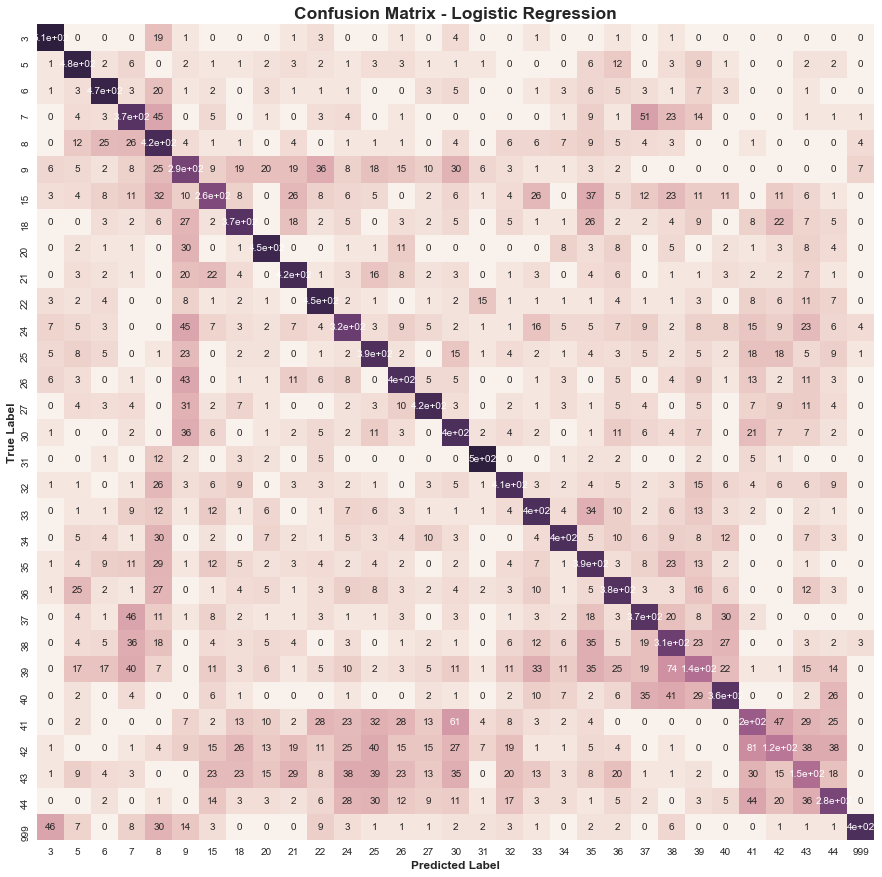

In [138]:
figsize(15, 15)
plot_confusion('Confusion Matrix - Logistic Regression',y_test, y_Log_pred)

#### KNN

In [139]:
from sklearn.neighbors import KNeighborsClassifier

In [140]:
k_range = list(range(1, 21))
k_scores = []

In [141]:
%%time
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_knn_pred = knn.predict(X_test)
    print('k=',k,'  Accuracy Score=',metrics.accuracy_score(y_test, y_knn_pred))
    k_scores.append(metrics.accuracy_score(y_test, y_knn_pred))  
    ## Here y_test is actual scores from the test set and y_pred are scores predicted by model for the test set data

k= 1   Accuracy Score= 0.709814228541
k= 2   Accuracy Score= 0.666925512216
k= 3   Accuracy Score= 0.675347948151
k= 4   Accuracy Score= 0.67140553133
k= 5   Accuracy Score= 0.667463114509
k= 6   Accuracy Score= 0.662027357983
k= 7   Accuracy Score= 0.65617346634
k= 8   Accuracy Score= 0.651932381578
k= 9   Accuracy Score= 0.647631563228
k= 10   Accuracy Score= 0.643569679231
k= 11   Accuracy Score= 0.641717937997
k= 12   Accuracy Score= 0.640463532644
k= 13   Accuracy Score= 0.638313123469
k= 14   Accuracy Score= 0.635505644824
k= 15   Accuracy Score= 0.636580849412
k= 16   Accuracy Score= 0.635206976883
k= 17   Accuracy Score= 0.63431097306
k= 18   Accuracy Score= 0.636580849412
k= 19   Accuracy Score= 0.634549907413
k= 20   Accuracy Score= 0.63299683412
CPU times: user 16min 39s, sys: 6.76 s, total: 16min 46s
Wall time: 17min 12s


In [142]:
max(k_scores)   # Best Accuracy at k=17

0.70981422854070841

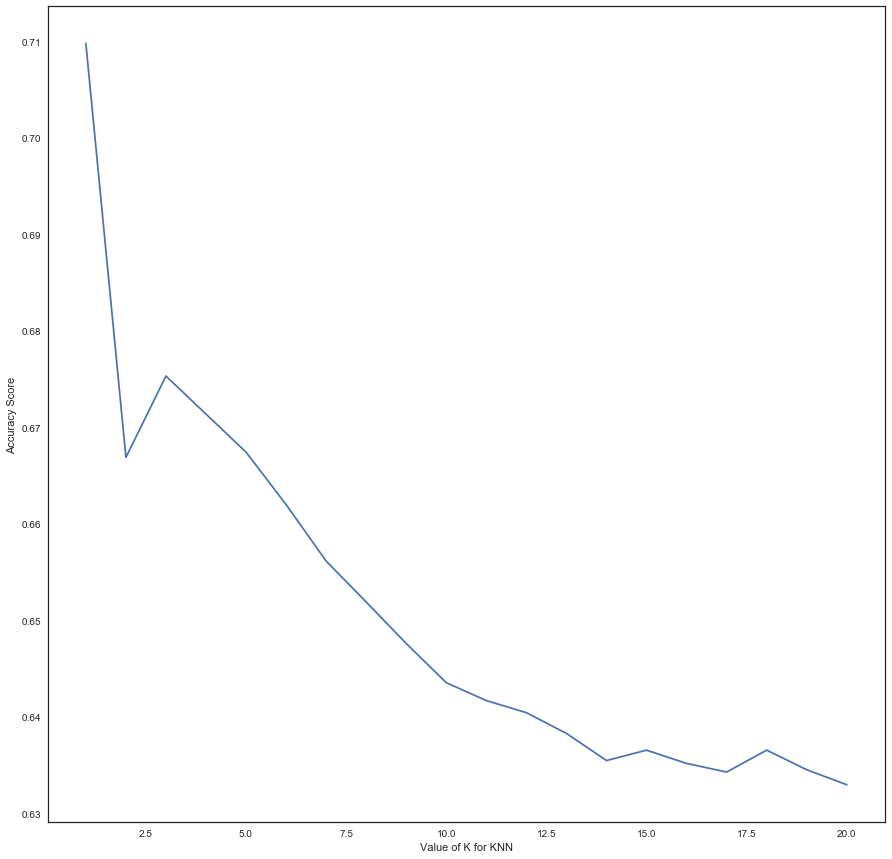

In [143]:
# plot the value of K for KNN (x-axis) versus the accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy Score')

#### KNN for 2ndbest accuracy score at k=  3  -------->>>>> BEST AT ~7
overfits at k=1 

In [149]:
%%time
knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(X_train, y_train)

y_knn_pred_train = knn.predict(X_train)
print('KNN (k=',k,') Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_knn_pred_train))   

KNN (k= 20 ) Accuracy Score (Train)= 0.804152479455
CPU times: user 1min 15s, sys: 655 ms, total: 1min 15s
Wall time: 1min 17s


In [150]:
%%time
y_knn_pred = knn.predict(X_test)
print('KNN (k=',k,') Accuracy Score(Test) =',metrics.accuracy_score(y_test, y_knn_pred))

KNN (k= 20 ) Accuracy Score(Test) = 0.675347948151
CPU times: user 31.9 s, sys: 137 ms, total: 32 s
Wall time: 32.1 s


In [151]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTrain = metrics.recall_score(y_train, y_knn_pred_train, average='micro')
print('Recall micro-average for KNN (Train) =', RecallTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTest = metrics.recall_score(y_test,  y_knn_pred, average='micro')
print('Recall micro-average for KNN (Test) =', RecallTest)

Recall micro-average for KNN (Train) = 0.804152479455
Recall micro-average for KNN (Test) = 0.675347948151


In [152]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTrain = metrics.precision_score(y_train, y_knn_pred_train, average='micro')
print('Precision micro-average for KNN (Train) =', PrecisionTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTest = metrics.precision_score(y_test, y_knn_pred, average='micro')
print('Precision micro-average for KNN (Test) =', PrecisionTest)

Precision micro-average for KNN (Train) = 0.804152479455
Precision micro-average for KNN (Test) = 0.675347948151


In [153]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Train = metrics.f1_score(y_train, y_knn_pred_train, average='micro')
print('F1_score micro-average for KNN (Train) =', F1Train)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Test = metrics.f1_score(y_test, y_knn_pred, average='micro')
print('F1_score micro-average for KNN (Test) =', F1Test)

F1_score micro-average for KNN (Train) = 0.804152479455
F1_score micro-average for KNN (Test) = 0.675347948151


In [223]:
%%time
y_knn_pred = knn.predict(X_test)
print('KNN (k=',3,') Accuracy Score(Test) =',metrics.accuracy_score(y_test, y_knn_pred))
print(classification_report(y_test, y_knn_pred))

KNN (k= 3 ) Accuracy Score(Test) = 0.675347948151
             precision    recall  f1-score   support

          3       0.79      0.83      0.81       540
          5       0.66      0.82      0.73       540
          6       0.74      0.88      0.80       540
          7       0.49      0.61      0.54       540
          8       0.54      0.64      0.58       540
          9       0.50      0.40      0.45       540
         15       0.63      0.76      0.69       540
         18       0.72      0.88      0.79       540
         20       0.84      0.93      0.88       540
         21       0.80      0.92      0.86       540
         22       0.77      0.81      0.79       540
         24       0.51      0.47      0.49       540
         25       0.59      0.54      0.57       540
         26       0.78      0.89      0.83       540
         27       0.82      0.88      0.85       540
         30       0.65      0.67      0.66       541
         31       0.94      0.94      0.94      

#### Confusion Matrix KNN, k=3

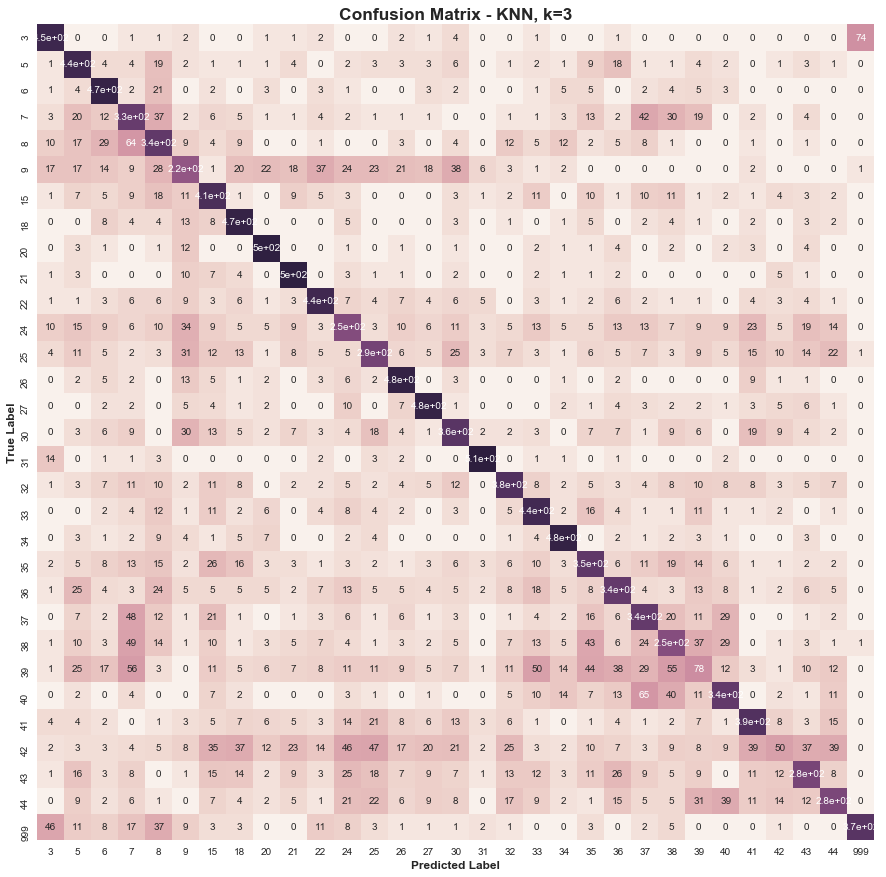

In [224]:
figsize(15, 15)
plot_confusion('Confusion Matrix - KNN, k=3',y_test, y_knn_pred)

#### Gaussian Naive Bayes

In [157]:
from sklearn.naive_bayes import GaussianNB 

In [244]:
%%time
GNB = GaussianNB()  #class_weight='balanced'
GNB.fit(X_train, y_train)

y_GNB_pred_train = GNB.predict(X_train)
print('Gaussian Naive Bayes Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_GNB_pred_train))

Gaussian Naive Bayes Accuracy Score (Train)= 0.344512429277
CPU times: user 799 ms, sys: 352 ms, total: 1.15 s
Wall time: 1.15 s


In [159]:
%%time
y_GNB_pred = GNB.predict(X_test)
print('Gaussian Naive Bayes Accuracy Score (Test)=',metrics.accuracy_score(y_test, y_GNB_pred))

Gaussian Naive Bayes Accuracy Score (Test)= 0.335463831312
CPU times: user 307 ms, sys: 155 ms, total: 462 ms
Wall time: 461 ms


#### Support Vector Machine

In [160]:
from sklearn import svm

#### Linear Kernel 

In [161]:
%%time
model_svm = svm.SVC(kernel='linear')    #,class_weight='balanced')
model_svm.fit(X_train, y_train);

y_SVM_pred_train = model_svm.predict(X_train)
print('SVM Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_SVM_pred_train))

SVM Accuracy Score (Train)= 0.727375131205
CPU times: user 3min 16s, sys: 1.62 s, total: 3min 18s
Wall time: 3min 21s


In [162]:
%%time
y_SVM_pred = model_svm.predict(X_test)
print('SVM Accuracy Score (Test)=',metrics.accuracy_score(y_test, y_SVM_pred))

SVM Accuracy Score (Test)= 0.6998984529
CPU times: user 44.5 s, sys: 336 ms, total: 44.8 s
Wall time: 45.4 s


In [163]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTrain = metrics.recall_score(y_train, y_SVM_pred_train, average='micro')
print('Recall micro-average for SVM Linear (Train) =', RecallTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTest = metrics.recall_score(y_test,  y_SVM_pred, average='micro')
print('Recall micro-average for SVM Linear (Test) =', RecallTest)

Recall micro-average for SVM Linear (Train) = 0.727375131205
Recall micro-average for SVM Linear (Test) = 0.6998984529


In [164]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTrain = metrics.precision_score(y_train, y_SVM_pred_train, average='micro')
print('Precision micro-average for SVM Linear (Train) =', PrecisionTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTest = metrics.precision_score(y_test, y_SVM_pred, average='micro')
print('Precision micro-average for SVM Linear (Test) =', PrecisionTest)

Precision micro-average for SVM Linear (Train) = 0.727375131205
Precision micro-average for SVM Linear (Test) = 0.6998984529


In [165]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Train = metrics.f1_score(y_train, y_SVM_pred_train, average='micro')
print('F1_score micro-average for SVM Linear (Train) =', F1Train)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Test = metrics.f1_score(y_test, y_SVM_pred, average='micro')
print('F1_score micro-average for SVM Linear (Test) =', F1Test)

F1_score micro-average for SVM Linear (Train) = 0.727375131205
F1_score micro-average for SVM Linear (Test) = 0.6998984529


#### Polynomial Kernel    --- worst results within SVM

In [208]:
%%time
model_svm_pol = svm.SVC(kernel='poly')  #,class_weight='balanced')
model_svm_pol.fit(X_train, y_train);

y_SVM_pol_pred_train = model_svm_pol.predict(X_train)
print('SVM (Polynomial) Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_SVM_pol_pred_train))

SVM (Polynomial) Accuracy Score (Train)= 0.564706484729
CPU times: user 5min 23s, sys: 2.29 s, total: 5min 25s
Wall time: 5min 31s


In [209]:
%%time
y_SVM_pol_pred = model_svm_pol.predict(X_test)
print('SVM (Polynomial) Accuracy Score (Test)=',metrics.accuracy_score(y_test, y_SVM_pol_pred))

SVM (Polynomial) Accuracy Score (Test)= 0.512036318022
CPU times: user 1min 1s, sys: 369 ms, total: 1min 1s
Wall time: 1min 2s


#### RBF Kernel   ----3rd Best Result

#### decision_function_shape :  default=’ovr’

In [214]:
%%time
model_svm_rbf = svm.SVC(kernel='rbf')        #,class_weight='balanced' already
model_svm_rbf.fit(X_train, y_train);

y_SVM_rbf_pred_train = model_svm_rbf.predict(X_train)
print('SVM (RBF) Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_SVM_rbf_pred_train))

SVM (RBF) Accuracy Score (Train)= 0.733007347482
CPU times: user 4min 19s, sys: 2.68 s, total: 4min 21s
Wall time: 4min 25s


In [215]:
%%time
y_SVM_rbf_pred = model_svm_rbf.predict(X_test)
print('SVM (RBF) Accuracy Score (Test)=',metrics.accuracy_score(y_test, y_SVM_rbf_pred))

SVM (RBF) Accuracy Score (Test)= 0.695060032256
CPU times: user 1min 2s, sys: 560 ms, total: 1min 3s
Wall time: 1min 3s


#### decision_function_shape : ‘ovo’  ----- Results of 'ovo' and 'ovr' are the same 

In [216]:
%%time
model_svm_rbf = svm.SVC(kernel='rbf',decision_function_shape = 'ovo') #,class_weight='balanced'
model_svm_rbf.fit(X_train, y_train);

y_SVM_rbf_pred_train = model_svm_rbf.predict(X_train)
print('SVM (RBF) Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_SVM_rbf_pred_train))

SVM (RBF) Accuracy Score (Train)= 0.733007347482
CPU times: user 4min 53s, sys: 2 s, total: 4min 55s
Wall time: 5min 2s


In [217]:
%%time
y_SVM_rbf_pred = model_svm_rbf.predict(X_test)
print('SVM (RBF) Accuracy Score (Test)=',metrics.accuracy_score(y_test, y_SVM_rbf_pred))

SVM (RBF) Accuracy Score (Test)= 0.695060032256
CPU times: user 1min 3s, sys: 393 ms, total: 1min 3s
Wall time: 1min 4s


In [218]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTrain = metrics.recall_score(y_train, y_SVM_rbf_pred_train, average='micro')
print('Recall micro-average for SVM RBF (Train) =', RecallTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTest = metrics.recall_score(y_test,  y_SVM_rbf_pred, average='micro')
print('Recall micro-average for SVM RBF (Test) =', RecallTest)

Recall micro-average for SVM RBF (Train) = 0.733007347482
Recall micro-average for SVM RBF (Test) = 0.695060032256


In [219]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTrain = metrics.precision_score(y_train, y_SVM_rbf_pred_train, average='micro')
print('Precision micro-average for SVM RBF (Train) =', PrecisionTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTest = metrics.precision_score(y_test, y_SVM_rbf_pred, average='micro')
print('Precision micro-average for SVM RBF (Test) =', PrecisionTest)

Precision micro-average for SVM RBF (Train) = 0.733007347482
Precision micro-average for SVM RBF (Test) = 0.695060032256


In [220]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Train = metrics.f1_score(y_train, y_SVM_rbf_pred_train, average='micro')
print('F1_score micro-average for SVM RBF (Train) =', F1Train)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Test = metrics.f1_score(y_test, y_SVM_rbf_pred, average='micro')
print('F1_score micro-average for SVM RBF (Test) =', F1Test)

F1_score micro-average for SVM RBF (Train) = 0.733007347482
F1_score micro-average for SVM RBF (Test) = 0.695060032256


In [221]:
print(classification_report(y_test, y_SVM_rbf_pred))

             precision    recall  f1-score   support

          3       0.88      0.92      0.90       540
          5       0.77      0.86      0.81       540
          6       0.83      0.84      0.84       540
          7       0.70      0.62      0.66       540
          8       0.59      0.73      0.65       540
          9       0.57      0.42      0.48       540
         15       0.68      0.53      0.60       540
         18       0.73      0.81      0.77       540
         20       0.75      0.92      0.83       540
         21       0.74      0.83      0.79       540
         22       0.78      0.72      0.75       540
         24       0.65      0.54      0.59       540
         25       0.64      0.66      0.65       540
         26       0.72      0.88      0.79       540
         27       0.79      0.87      0.83       540
         30       0.64      0.77      0.70       541
         31       0.91      0.93      0.92       540
         32       0.73      0.84      0.78   

#### Confusion Matrix - SVM, kernel ='rbf'

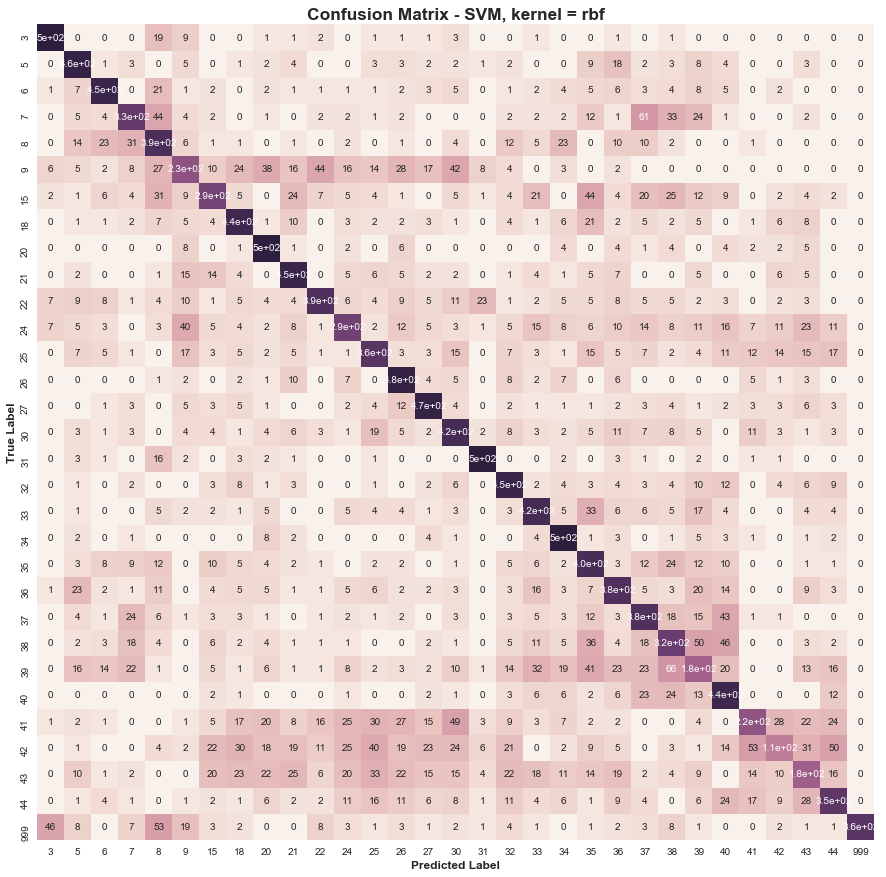

In [222]:
figsize(15, 15)
plot_confusion('Confusion Matrix - SVM, kernel = rbf',y_test, y_SVM_rbf_pred)

#### Decision Tree Classifier

In [210]:
from sklearn.tree import DecisionTreeClassifier

In [211]:
%%time
DTC = DecisionTreeClassifier(max_depth=15)      #class_weight='balanced' already
DTC.fit(X_train, y_train);

y_DTC_pred_train = DTC.predict(X_train)
print('Decision Tree Classifier Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_DTC_pred_train))

Decision Tree Classifier Accuracy Score (Train)= 0.55423568265
CPU times: user 393 ms, sys: 27.9 ms, total: 421 ms
Wall time: 423 ms


In [212]:
%%time
y_DTC_pred = DTC.predict(X_test)
print('Decision Tree Classifier Accuracy Score(Test)=',metrics.accuracy_score(y_test, y_DTC_pred))

Decision Tree Classifier Accuracy Score(Test)= 0.512573920315
CPU times: user 13.2 ms, sys: 7.81 ms, total: 21 ms
Wall time: 19.4 ms


In [183]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTrain = metrics.recall_score(y_train, y_DTC_pred_train, average='micro')
print('Recall micro-average for DTC (Train) =', RecallTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTest = metrics.recall_score(y_test,  y_DTC_pred, average='micro')
print('Recall micro-average for DTC (Test) =', RecallTest)

Recall micro-average for DTC (Train) = 0.55423568265
Recall micro-average for DTC (Test) = 0.512394719551


In [184]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTrain = metrics.precision_score(y_train,  y_DTC_pred_train, average='micro')
print('Precision micro-average for DTC (Train) =', PrecisionTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTest = metrics.precision_score(y_test, y_DTC_pred, average='micro')
print('Precision micro-average for DTC (Test) =', PrecisionTest)

Precision micro-average for DTC (Train) = 0.55423568265
Precision micro-average for DTC (Test) = 0.512394719551


In [185]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Train = metrics.f1_score(y_train,y_DTC_pred_train, average='micro')
print('F1_score micro-average for DTC (Train) =', F1Train)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Test = metrics.f1_score(y_test, y_DTC_pred, average='micro')
print('F1_score micro-average for DTC (Test) =', F1Test)

F1_score micro-average for DTC (Train) = 0.55423568265
F1_score micro-average for DTC (Test) = 0.512394719551


#### Random Forest Classifier  - 2nd BEST

In [186]:
from sklearn.ensemble import RandomForestClassifier

In [199]:
%%time
RFC =  RandomForestClassifier(class_weight='balanced',min_samples_split=45)
RFC.fit(X_train, y_train);

y_RFC_pred_train = RFC.predict(X_train)
print('Random Forest Classifier Accuracy Score (Train)=',metrics.accuracy_score(y_train, y_RFC_pred_train))

Random Forest Classifier Accuracy Score (Train)= 0.780189959294
CPU times: user 848 ms, sys: 69.2 ms, total: 918 ms
Wall time: 920 ms


In [200]:
%%time
y_RFC_pred = RFC.predict(X_test)
print('Random Forest Classifier Accuracy Score(Test)=',metrics.accuracy_score(y_test, y_RFC_pred))

Random Forest Classifier Accuracy Score(Test)= 0.705931545308
CPU times: user 95.1 ms, sys: 30.6 ms, total: 126 ms
Wall time: 124 ms


In [201]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTrain = metrics.recall_score(y_train, y_RFC_pred_train, average='micro')
print('Recall micro-average for RFC (Train) =', RecallTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

RecallTest = metrics.recall_score(y_test,   y_RFC_pred, average='micro')
print('Recall micro-average for RFC (Test) =', RecallTest)

Recall micro-average for RFC (Train) = 0.780189959294
Recall micro-average for RFC (Test) = 0.705931545308


In [202]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTrain = metrics.precision_score(y_train,  y_RFC_pred_train, average='micro')
print('Precision micro-average for RFC (Train) =', PrecisionTrain)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

PrecisionTest = metrics.precision_score(y_test, y_RFC_pred, average='micro')
print('Precision micro-average for RFC (Test) =', PrecisionTest)

Precision micro-average for RFC (Train) = 0.780189959294
Precision micro-average for RFC (Test) = 0.705931545308


In [203]:
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Train = metrics.f1_score(y_train,y_RFC_pred_train, average='micro')
print('F1_score micro-average for RFC (Train) =', F1Train)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives

F1Test = metrics.f1_score(y_test,y_RFC_pred, average='micro')
print('F1_score micro-average for RFC (Test) =', F1Test)

F1_score micro-average for RFC (Train) = 0.780189959294
F1_score micro-average for RFC (Test) = 0.705931545308


In [204]:
%%time
y_RFC_pred = RFC.predict(X_test)
print('Random Forest Classifier Accuracy Score(Test)=',metrics.accuracy_score(y_test, y_RFC_pred))
print(classification_report(y_test, y_RFC_pred))

Random Forest Classifier Accuracy Score(Test)= 0.705931545308
             precision    recall  f1-score   support

          3       0.85      0.97      0.90       540
          5       0.85      0.80      0.82       540
          6       0.82      0.88      0.85       540
          7       0.72      0.59      0.64       540
          8       0.64      0.72      0.68       540
          9       0.70      0.37      0.48       540
         15       0.71      0.61      0.65       540
         18       0.72      0.89      0.80       540
         20       0.80      0.95      0.86       540
         21       0.77      0.90      0.83       540
         22       0.79      0.87      0.83       540
         24       0.65      0.55      0.59       540
         25       0.61      0.60      0.61       540
         26       0.73      0.91      0.81       540
         27       0.77      0.92      0.84       540
         30       0.67      0.79      0.73       541
         31       0.87      0.97    

#### Confusion Matrix- Random Forest

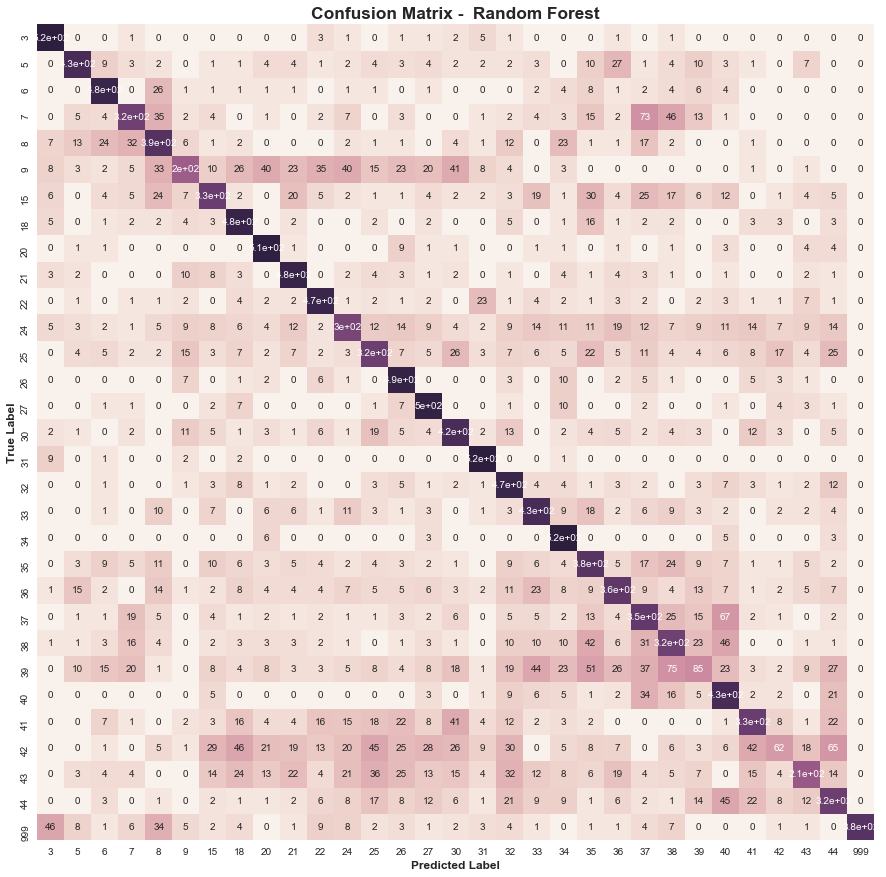

In [205]:
figsize(15, 15)
plot_confusion('Confusion Matrix -  Random Forest',y_test, y_RFC_pred)

## Grid Search CV

In [249]:
RFC =  RandomForestClassifier()      #class_weight='balanced',

In [250]:
# define the parameter values that should be searched
Min_range = list(range(5, 61,5))  
print(Min_range)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]


In [251]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(min_samples_split=Min_range)
print(param_grid)

{'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]}


In [254]:
# instantiate the grid
grid = GridSearchCV(RFC, param_grid, cv=10, scoring='accuracy')

In [255]:
# fit grid with data(Train set used here for cross validation -- test set would be used as a hold out for predict scores)
grid.fit(X_train, y_train);

In [256]:
# view the complete results (list of named tuples)

grid.grid_scores_

/Users/sdutta/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.74110, std: 0.00507, params: {'min_samples_split': 5},
 mean: 0.73265, std: 0.00335, params: {'min_samples_split': 10},
 mean: 0.72458, std: 0.00477, params: {'min_samples_split': 15},
 mean: 0.71619, std: 0.00498, params: {'min_samples_split': 20},
 mean: 0.71332, std: 0.00236, params: {'min_samples_split': 25},
 mean: 0.70730, std: 0.00583, params: {'min_samples_split': 30},
 mean: 0.70134, std: 0.00609, params: {'min_samples_split': 35},
 mean: 0.69955, std: 0.00685, params: {'min_samples_split': 40},
 mean: 0.69343, std: 0.00481, params: {'min_samples_split': 45},
 mean: 0.69304, std: 0.00387, params: {'min_samples_split': 50},
 mean: 0.69041, std: 0.00444, params: {'min_samples_split': 55},
 mean: 0.69064, std: 0.00598, params: {'min_samples_split': 60}]

In [257]:
# examine the best model
print("Best Accuracy Score: ", grid.best_score_)
print("Best Param: ",grid.best_params_)
print("Best Estimator: ",grid.best_estimator_)

Best Accuracy Score:  0.741097258135
Best Param:  {'min_samples_split': 5}
Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [259]:
from sklearn.model_selection import cross_val_score

In [260]:
%%time
classifier = grid.best_estimator_
CV_Accuracy = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy').mean()
CV_Precision = cross_val_score(classifier, X_train, y_train, cv=10, scoring='precision_micro').mean()
CV_Recall = cross_val_score(classifier, X_train, y_train, cv=10, scoring='recall_micro').mean()
CV_F1 = cross_val_score(classifier, X_train, y_train, cv=10, scoring='f1_micro').mean()

print('RFC (min_samples_split=5) CV Scores ')  
print("Cross Validated Accuracy:   %0.4f" %(CV_Accuracy))
print("Cross Validated Precision:  %0.4f" %(CV_Precision))
print("Cross Validated Recall:     %0.4f" %(CV_Recall))
print("Cross Validated F1:         %0.4f" %(CV_F1))

RFC (min_samples_split=5) CV Scores 
Cross Validated Accuracy:   0.7414
Cross Validated Precision:  0.7421
Cross Validated Recall:     0.7427
Cross Validated F1:         0.7419
CPU times: user 30.5 s, sys: 2.36 s, total: 32.9 s
Wall time: 33.4 s


#### Combination of KNN RFC and Logistic

In [206]:
len(y_RFC_pred), len(y_knn_pred), len(y_Log_pred)

(16741, 16741, 16741)

In [207]:
y_ens = []
for i in range(len(y_RFC_pred)):
    if y_RFC_pred[i]==y_SVM_rbf_pred[i]:
        y_ens.append(y_RFC_pred[i])
    else:
        y_ens.append(y_knn_pred[i])
print('Combined Classifier Accuracy Score(Test)=',metrics.accuracy_score(y_test, y_ens))
print(classification_report(y_test, y_ens))

NameError: name 'y_SVM_rbf_pred' is not defined

In [ ]:
logregM = LogisticRegression(C=1, penalty='l2', random_state=0, class_weight='balanced')

logregM.fit(X_train_scaled, y_train)